# Install dependencies

In [1]:
#!pip install git+https://github.com/modAL-python/modAL.git

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from modAL.disagreement import max_std_sampling
from modAL.models import ActiveLearner, CommitteeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from modAL.uncertainty import uncertainty_sampling

# Load dataset

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_pool, X_test, Y_pool, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training shape: " + str(X_train.shape))
print("Training shape: " + str(y_train.shape))
print("Unlabeled shape: " + str(X_pool.shape))
print("Testing shape: " + str(X_test.shape))
print("Testing shape: " + str(y_test.shape))

Training shape: (265, 10)
Training shape: (265,)
Unlabeled shape: (88, 10)
Testing shape: (89, 10)
Testing shape: (89,)


# Active learning with entropy sampling

In [ ]:
# 1 learner me olo to training

In [6]:
learners = []
split_size = len(X_train) // 4
print(split_size)
queries = len(X_pool)

model = RandomForestRegressor(random_state=0)

for i in range(4):
    start_index = i * split_size
    end_index = (i + 1) * split_size
    X_subset = X_train[start_index:end_index]
    y_subset = y_train[start_index:end_index]
    learner = ActiveLearner(estimator=model, X_training=X_subset, y_training=y_subset)
    learners.append(learner)
    
committee = CommitteeRegressor(
    learner_list=learners,
    query_strategy=max_std_sampling #unceratinenty
)

66


In [7]:
x_pool = X_pool
y_pool = Y_pool

scores_mss = []
for i in range(queries):
    index, _ = committee.query(x_pool)
    index = index[0]
    x = x_pool[index]
    y = y_pool[index]
    x_pool = np.delete(x_pool, obj=index, axis=0)
    y_pool = np.delete(y_pool, obj=index, axis=0)
    committee.teach(X=[x], y=[y])
    y_pred = committee.predict(X_test)        
    r2 = r2_score(y_test, y_pred)
    if i%20 == 0:
        print(f"R2 score after query {str(i)}: {r2:0.4f}")
    scores_mss.append(r2)

R2 score after query 0: 0.3821
R2 score after query 20: 0.3881
R2 score after query 40: 0.4427
R2 score after query 60: 0.4827
R2 score after query 80: 0.4909


# Active learning with random sampling

In [6]:
x_pool = X_pool
y_pool = Y_pool

scores_rs = []
for i in range(queries):
    index = random.randint(0, len(x_pool) - 1)
    x = x_pool[index]
    y = y_pool[index]
    x_pool = np.delete(x_pool, obj=index, axis=0)
    y_pool = np.delete(y_pool, obj=index, axis=0)
    committee.teach(X=[x], y=[y])
    y_pred = committee.predict(X_test)        
    r2 = r2_score(y_test, y_pred)
    if i%20 == 0:
        print(f"R2 score after query {str(i)}: {r2:0.4f}")
    scores_rs.append(r2)

R2 score after query 0: 0.4957
R2 score after query 20: 0.4910
R2 score after query 40: 0.5065
R2 score after query 60: 0.4897
R2 score after query 80: 0.4834


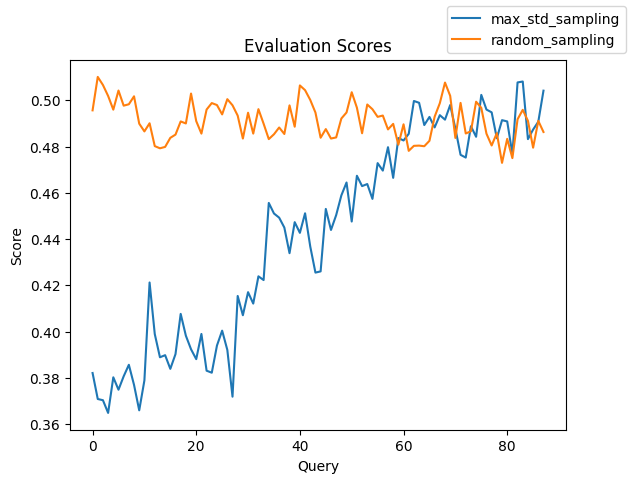

In [7]:
fig, ax = plt.subplots()

ax.plot(range(len(scores_mss)), scores_mss, label="max_std_sampling")
ax.plot(range(len(scores_rs)), scores_rs, label="random_sampling")
ax.set_title('Evaluation Scores')
ax.set(xlabel='Query', ylabel='Score')
fig.legend()

plt.show()